# **Gradient Boosting with XGBoost**
We'll perform the following steps:-
1. Downloading a real-world dataset from a Kaggle competition
2. Performing feature engineering and prepare the dataset for training
3. Training and interpreting a gradient boosting model using XGBoost
4. Training with KFold cross-validation and ensembling results
5. Configuring the gradient boosting model and tuning hyperparameters

Let's begin by installing the required libraries.

In [3]:
!pip install numpy pandas-profiling matplotlib seaborn --quiet

In [4]:
!pip install opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

## **Problem Statement**
We'll learn gradient boosting by applying it to a real-world dataset from the **Rossmann Store Sales** from kaggle.

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.

With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. We are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Some stores in the dataset were temporarily closed for refurbishment.

View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

# **Downloading the Dataset**

In [5]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [6]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chanchalsaytode
Your Kaggle Key: ··········


100%|██████████| 6.99M/6.99M [00:00<00:00, 129MB/s]


Extracting archive ./rossmann-store-sales/rossmann-store-sales.zip to ./rossmann-store-sales


In [7]:
os.listdir('rossmann-store-sales')

['train.csv', 'store.csv', 'test.csv', 'sample_submission.csv']

Let's load the data into Pandas dataframes.

In [8]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [9]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [10]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [11]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [12]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Let's merge the information from `store_df` into `train_df` and `test_df`.

In [13]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [14]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [15]:
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# **Preprocessing and Feature Engineering**

In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

**Date**

Let's convert Date to a datecolumn and extract different parts of the date.

In [17]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.day

In [18]:
split_date(merged_df)
split_date(merged_test_df)

In [19]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


**Store Open/Closed**

Notice that the sales are zero whenever the store is closed.

In [20]:
merged_df[merged_df.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

Remove the rows where the store is closed.

In [21]:
merged_df = merged_df[merged_df.Open == 1].copy()

**Competition**

Use the columns CompetitionOpenSince[Month/Year] columns from store_df to compute the number of months for which a competitor has been open near the store.

In [22]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [23]:
comp_months(merged_df)
comp_months(merged_test_df)

In [24]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


New column will look like this now.

In [25]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
240692,2014-12-27,18760.0,2015.0,8.0,0.0
630785,2013-12-13,7470.0,NaN,NaN,0.0
629623,2013-12-14,13020.0,2003.0,8.0,124.0
267609,2014-11-28,1510.0,2013.0,9.0,14.0
447629,2014-05-26,1860.0,2015.0,5.0,0.0
169110,2015-03-02,4330.0,2011.0,2.0,49.0
943507,2013-03-08,170.0,2013.0,7.0,0.0
705427,2013-10-07,1060.0,2009.0,5.0,53.0
728808,2013-09-16,130.0,NaN,NaN,0.0
494058,2014-04-15,2590.0,NaN,NaN,0.0


**Additional Promotion**

To indicate how long a store has been running Promo2 and whether a new round of Promo2 starts in the current month.

In [26]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [27]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [28]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
652657,2013-11-23,0,NaN,NaN,NaN,0.000000,0
845151,2013-06-04,0,NaN,NaN,NaN,0.000000,0
261073,2014-12-05,0,NaN,NaN,NaN,0.000000,0
719161,2013-09-25,0,NaN,NaN,NaN,0.000000,0
958133,2013-02-22,1,2011.0,22.0,"Mar,Jun,Sept,Dec",24.000000,0
920771,2013-03-28,1,2011.0,18.0,"Feb,May,Aug,Nov",26.295082,0
599912,2014-01-10,0,NaN,NaN,NaN,0.000000,0
150884,2015-03-18,0,NaN,NaN,NaN,0.000000,0
513325,2014-03-28,1,2009.0,37.0,"Jan,Apr,Jul,Oct",57.934426,0
521982,2014-03-21,0,NaN,NaN,NaN,0.000000,0


## **Input and Target Columns**
Let's select the columns that we'll use for training.

In [29]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [30]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [31]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [32]:
test_inputs = merged_test_df[input_cols].copy()

In [33]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

# Impute missing numerical data

In [34]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [35]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [36]:
max_distance = inputs.CompetitionDistance.max()

In [37]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

**Scale Numeric Values**

Let's scale numeric values to the 0 to 1 range.

In [38]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

**Encode Categorical Columns**

Let's one-hot encode categorical columns.

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [43]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# **Gradient Boosting**

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model.

We'll now train our gradient boosting machine (GBM) model.

**Training**

To train a GBM, we can use the XGBRegressor class from the XGBoost library.

In [44]:
from xgboost import XGBRegressor

In [45]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [46]:
%%time
model.fit(X, targets)

CPU times: user 43.8 s, sys: 359 ms, total: 44.2 s
Wall time: 25.8 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

Prediction

We can now make predictions and evaluate the model using model.predict.

In [47]:
preds = model.predict(X)

In [48]:
preds

array([ 8096.784 ,  7647.2515,  8223.454 , ...,  8181.927 ,  7327.6045,
       10273.97  ], dtype=float32)

Evaluation

Let's evaluate the predictions using RMSE error.

In [49]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [50]:
rmse(preds, targets)

2362.8043132809735

Visualization

We can visualize individual trees using plot_tree.

In [51]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

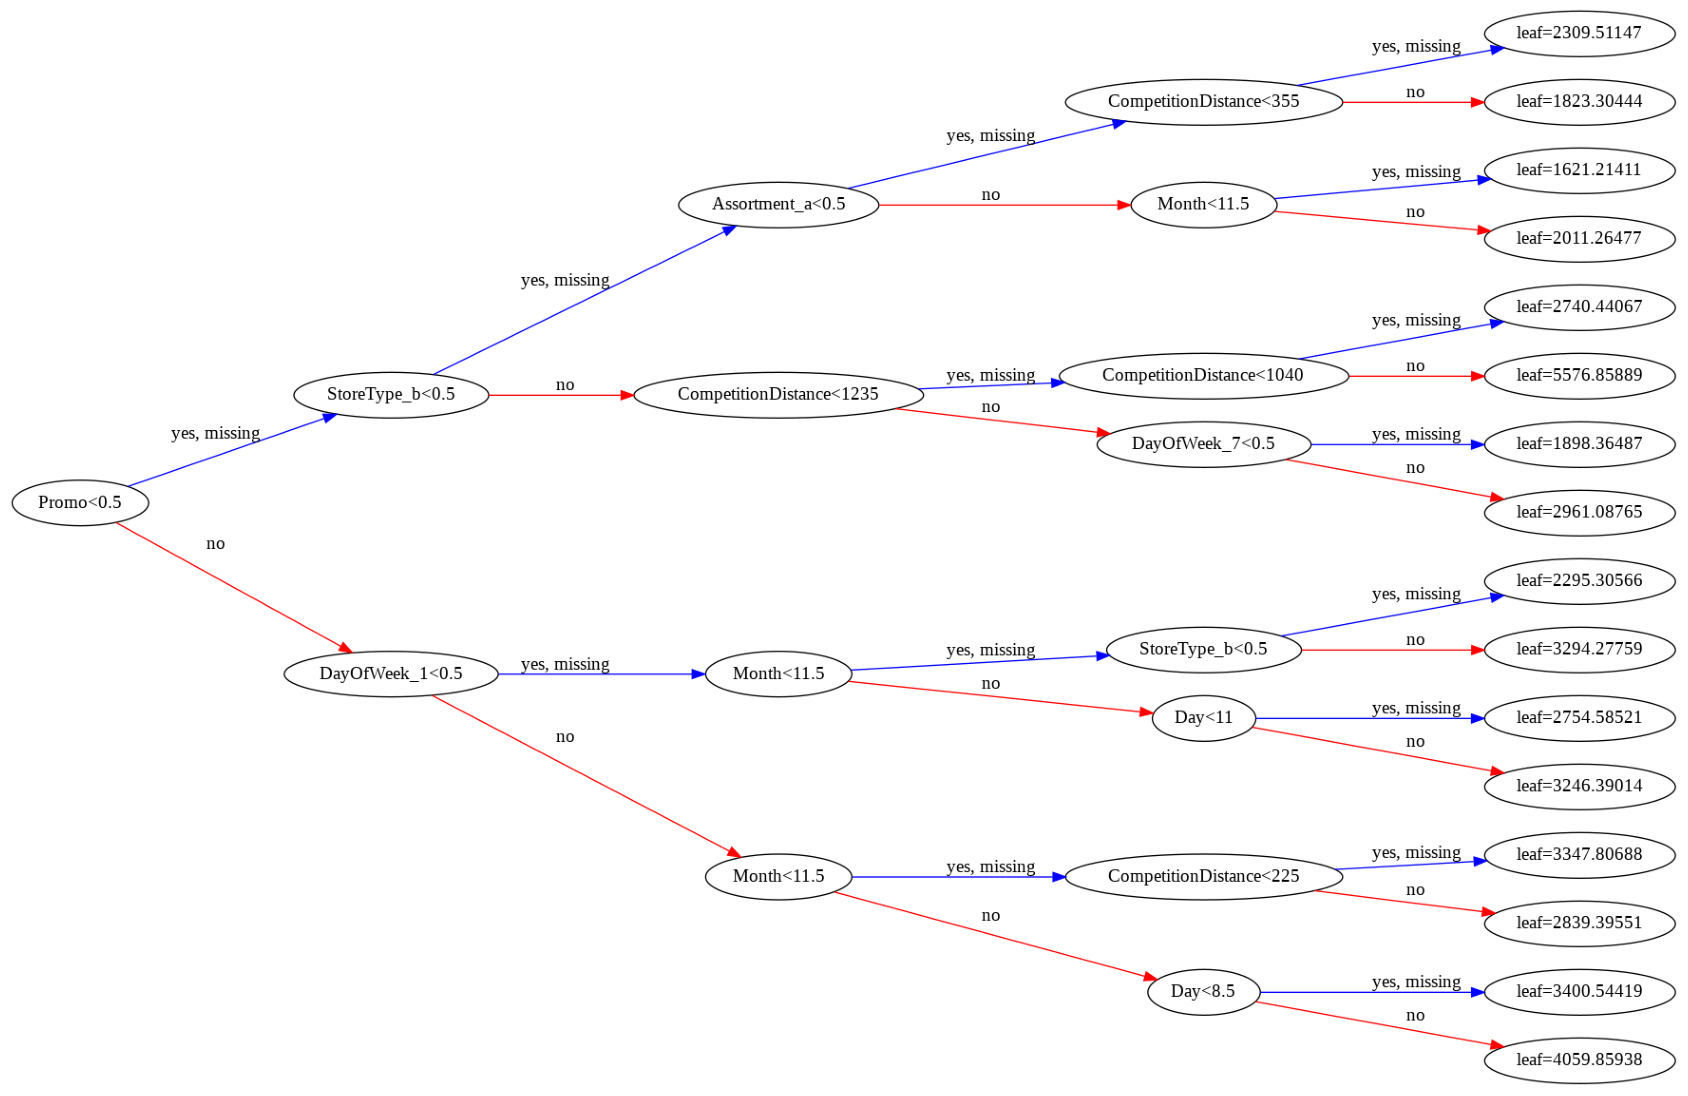

In [52]:
plot_tree(model, rankdir='LR');

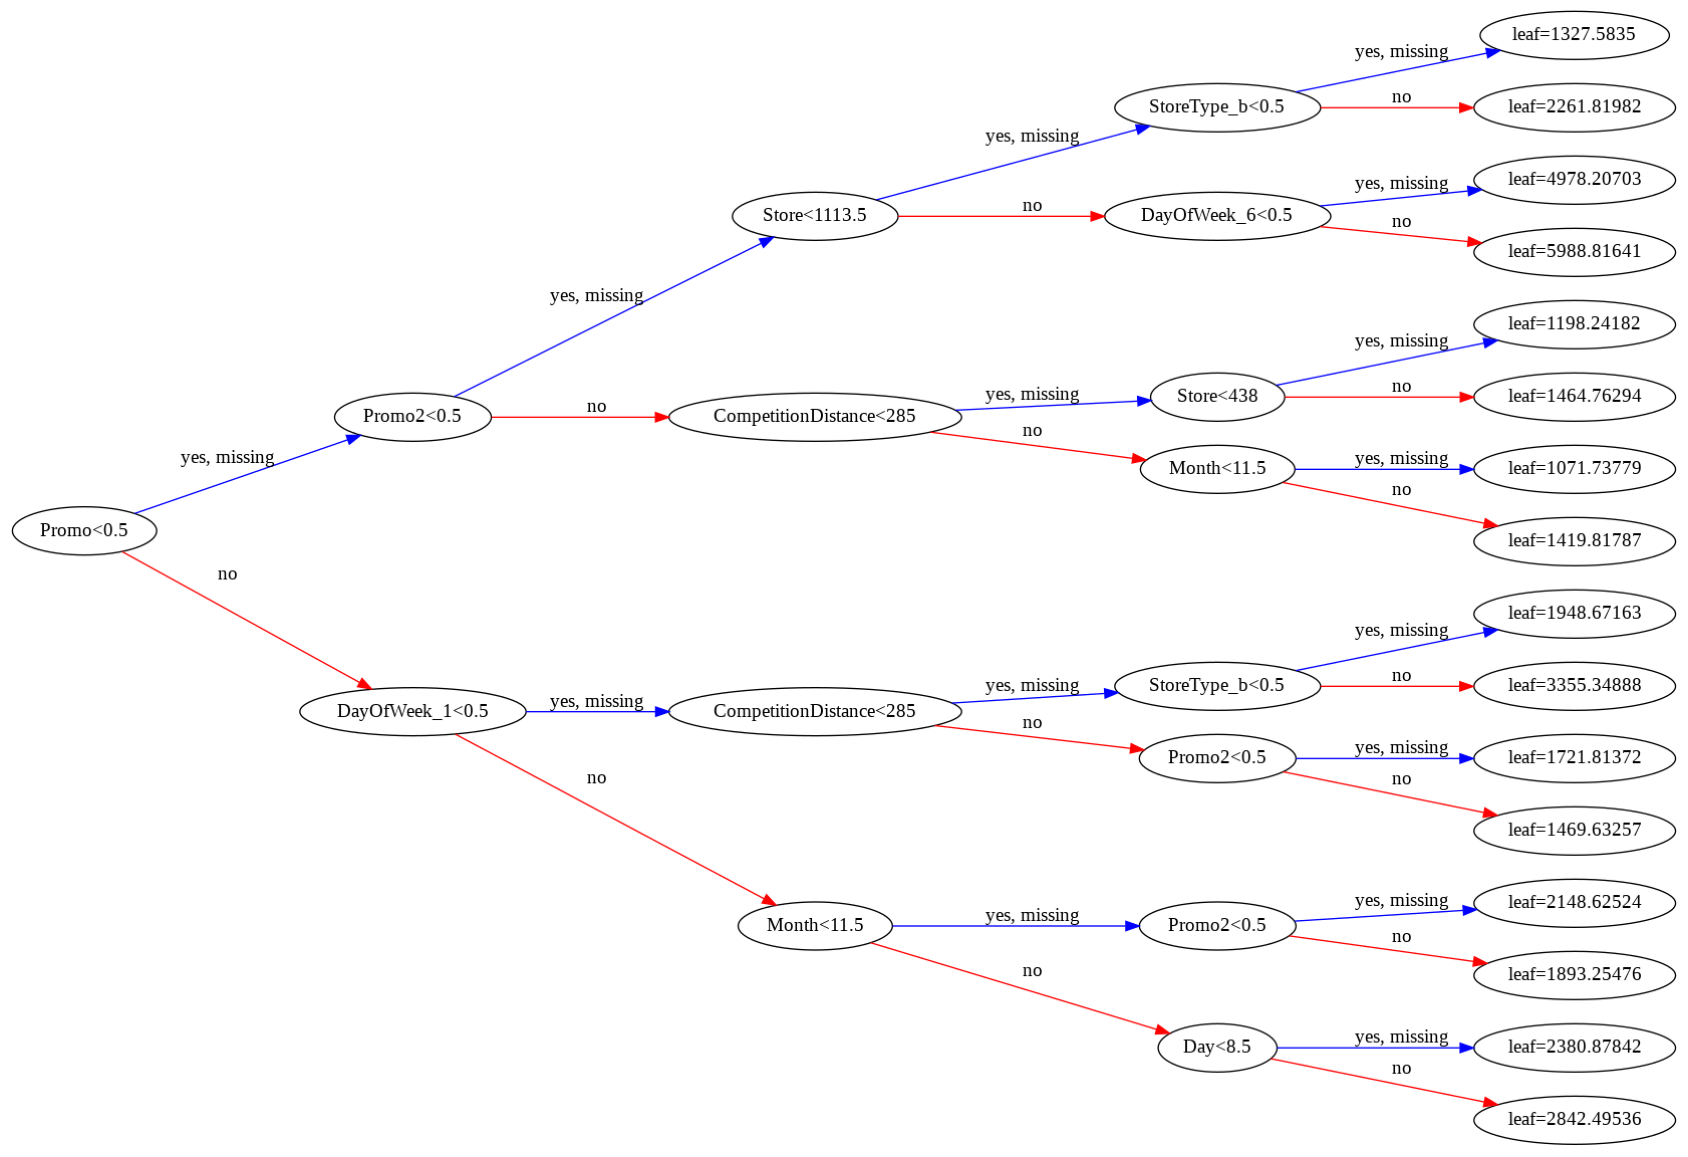

In [53]:
plot_tree(model, rankdir='LR', num_trees=1);

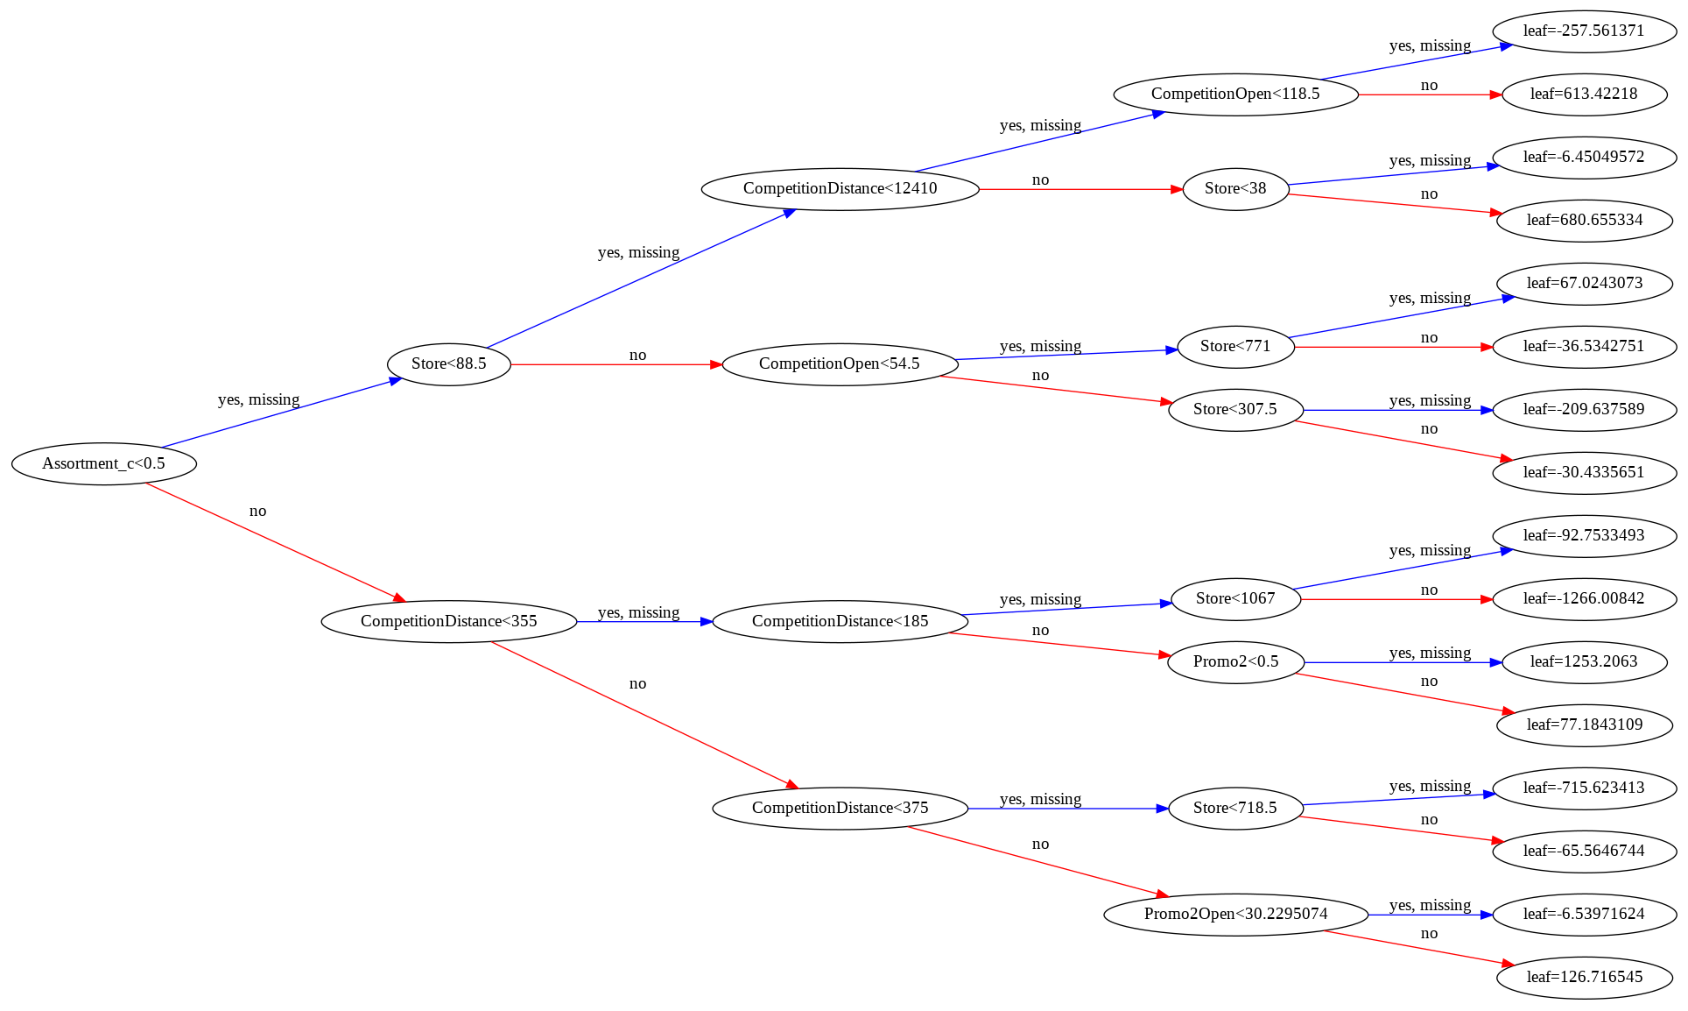

In [54]:
plot_tree(model, rankdir='LR', num_trees=19);

We have seen trees only compute residuals, and not the actual target value.

Now, we will visualize the tree as text.

In [55]:
trees = model.get_booster().get_dump()

In [56]:
len(trees)

20

In [57]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<355] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[Month<12] yes=17,no=18,missing=17
				17:leaf=1621.21411
				18:leaf=2011.26477
		4:[CompetitionDistance<1235] yes=9,no=10,missing=9
			9:[CompetitionDistance<1040] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[Month<12] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<11] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[Month<12] yes=13,no=14,missing=13
			13:[CompetitionDistance<225] yes=27,no=28,missing=27
				27:leaf=3347.80688
				28:leaf=2839.39551
			14:[Day<9] yes=29,no=30,missing=29
				29

## **Feature importance**
Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [58]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [59]:
importance_df.head(10)

,feature,importance
1,Promo,0.305091
12,DayOfWeek_1,0.111826
24,StoreType_b,0.074198
28,Assortment_b,0.067785
5,Promo2,0.066758
0,Store,0.043477
27,Assortment_a,0.037626
3,CompetitionDistance,0.035655
25,StoreType_c,0.033626
9,Month,0.029172


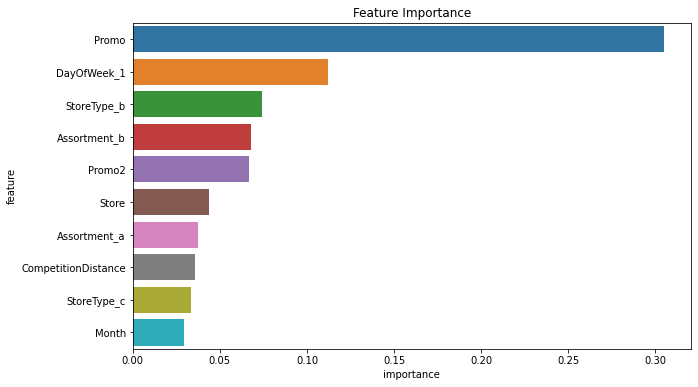

In [60]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

# **K Fold Cross Validation**
As we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation
Scikit-learn provides utilities for performing K fold cross validation.

In [61]:
from sklearn.model_selection import KFold

Let's define a helper function train_and_evaluate which trains a model the given parameters and returns the trained model, training error and validation error.

In [62]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the KFold utility to create the different training/validations splits and train a separate model for each fold.



In [63]:
kfold = KFold(n_splits=5)

In [64]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2395.1078122713484, Validation RMSE: 2446.9966482676255
Train RMSE: 2364.4517588623307, Validation RMSE: 2430.9063346162884
Train RMSE: 2402.779568203794, Validation RMSE: 2365.2725074468863
Train RMSE: 2343.509240051941, Validation RMSE: 2450.052071818772
Train RMSE: 2371.8503760384465, Validation RMSE: 2418.7935366982833


Let's also define a function to average predictions from the 5 different models.

In [65]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [66]:
preds = predict_avg(models, X)

In [67]:
preds

array([8048.9854, 7472.15  , 8309.684 , ..., 7219.686 , 7903.3594,
       9765.505 ], dtype=float32)

# **Hyperparameter Tuning and Regularization**
Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

In [68]:
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

Function to test hyperparameters with K-fold cross validation.

In [69]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [72]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

**n_estimators**

The number of trees to be created. 
More trees = greater capacity of the model.

In [73]:
test_params(n_estimators=10)

Train RMSE: 2339.6075304347546, Validation RMSE: 2359.1544309007154


In [74]:
test_params(n_estimators=30)

Train RMSE: 1901.4450640297568, Validation RMSE: 1913.3760643268217


In [75]:
test_params(n_estimators=100)

Train RMSE: 1186.8047101898399, Validation RMSE: 1194.003223821553


In [76]:
test_params(n_estimators=240)

Train RMSE: 903.1210537695463, Validation RMSE: 919.4376018817375


**max_depth**

As we increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [77]:
test_params(max_depth=2)

Train RMSE: 2374.2687695247764, Validation RMSE: 2388.687992059994


In [78]:
test_params(max_depth=5)

Train RMSE: 1414.702684651688, Validation RMSE: 1417.6487527906154


In [79]:
test_params(max_depth=10)

Train RMSE: 689.4055101893571, Validation RMSE: 783.8444756410429


**learning_rate**

The scaling factor to be applied to the prediction of each tree. 
A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [80]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 5042.332407282097, Validation RMSE: 5051.68411195169


In [81]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2162.348823505481, Validation RMSE: 2177.0357369158537


In [82]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 1568.911148976808, Validation RMSE: 1573.935648301826


In [83]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 1127.4155407171193, Validation RMSE: 1136.4798033919242


In [84]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 1158.524087993972, Validation RMSE: 1167.5895026017051


# **Putting it Together and Making Predictions**

Let's train a final model on the entire training set with custom hyperparameters.

In [85]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [86]:
%%time
model.fit(X, targets)

CPU times: user 1h 13min 2s, sys: 7.42 s, total: 1h 13min 10s
Wall time: 38min


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

Now that the model is trained, we can make predictions on the test set.

In [87]:
test_preds = model.predict(X_test)

Let's add the predictions into `submission_df`.

In [88]:
submission_df['Sales']  = test_preds

If the store is not open, then the sales must be 0. Thus, wherever the value of Open in the test set is 0, we can set the sales to 0. Also, there some missing values for Open in the test set. We'll replace them with 1 (open).

In [89]:
test_df.Open.isna().sum()

11

In [90]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [91]:
submission_df

,Id,Sales
0,1,3385.110840
1,2,7582.138672
2,3,9380.798828
3,4,6802.356445
4,5,6207.236328
...,...,...
41083,41084,2339.095703
41084,41085,6758.265137
41085,41086,6060.160156
41086,41087,24283.035156


We can now save the predictions as a CSV file.

In [92]:
submission_df.to_csv('submission.csv', index=None)